## Implement Fine-tuning of Diffusion models code with RTB for amortized sampler from posterior distribution with conditions

In [62]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import deque

In [63]:
# seed reproduction
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [64]:
# Define base distribution
mu1 = -1.0
sigma1 = 1.0
mu2 = 4.0
sigma2 = 1.0
mix_ratio = 0.4

mu_rf1 = -1.0
sigma_rf1 = 2.5

mu_rf2 = 4.0
sigma_rf2 = 2.5

x_min = -7.5
x_max = 7.5

def p0(x):
    return torch.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)

def p1(x):
    return mix_ratio * torch.exp(-0.5 * ((x - mu1) / sigma1) ** 2) / (sigma1 * np.sqrt(2 * np.pi)) + \
           (1 - mix_ratio) * torch.exp(-0.5 * ((x - mu2) / sigma2) ** 2) / (sigma2 * np.sqrt(2 * np.pi))
           
def p2(x):
    return (1 - mix_ratio) * torch.exp(-0.5 * ((x - mu1) / sigma1) ** 2) / (sigma1 * np.sqrt(2 * np.pi)) + \
            mix_ratio * torch.exp(-0.5 * ((x - mu2) / sigma2) ** 2) / (sigma2 * np.sqrt(2 * np.pi))

def r1(x):
    return torch.exp(-0.5 * ((x - mu_rf1) / sigma_rf1) ** 2) / (sigma_rf1 * np.sqrt(2 * np.pi))

def r2(x):
    return torch.exp(-0.5 * ((x - mu_rf2) / sigma_rf2) ** 2) / (sigma_rf2 * np.sqrt(2 * np.pi))

def r(x, y):
    return torch.where(y == 0, r1(x), r2(x))

x_linspace = torch.linspace(x_min, x_max, 1000)
Z1 = torch.trapz(p1(x_linspace) * r1(x_linspace), x_linspace)
Z2 = torch.trapz(p2(x_linspace) * r2(x_linspace), x_linspace)

def pr1(x):
    return p1(x) * r1(x) / Z1

def pr2(x):
    return p2(x) * r2(x) / Z2

In [65]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples):
        num_samples_half = num_samples // 2
        self.data = torch.cat([
            torch.normal(mu1, sigma1, (int(num_samples_half * mix_ratio), 1)),
            torch.normal(mu2, sigma2, (int(num_samples_half * (1 - mix_ratio)), 1))
        ], dim=0)
        
        self.data = torch.cat([
            self.data,
            torch.normal(mu1, sigma1, (int(num_samples_half * (1 - mix_ratio)), 1)),
            torch.normal(mu2, sigma2, (int(num_samples_half * mix_ratio), 1))
        ], dim=0)
        
        self.data_mean = self.data.mean(dim=0).unsqueeze(0)
        self.data_std = self.data.std(dim=0).unsqueeze(0)
        
        self.labels = torch.cat([
            torch.zeros(num_samples_half),
            torch.ones(num_samples_half)
        ], dim=0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

(-7.5, 7.5, 0.0, 0.3559701696038246)

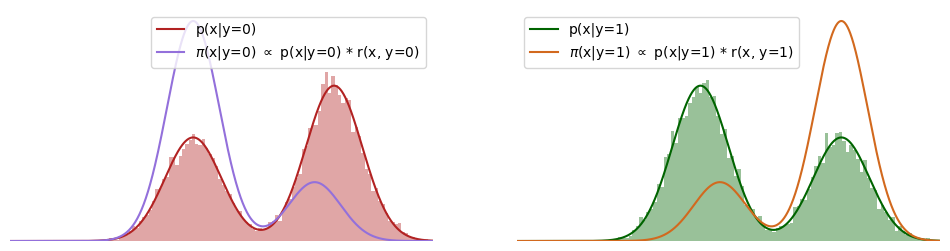

In [67]:
x_linspace = torch.linspace(x_min, x_max, 1000)

num_samples = 20000
dataset = ToyDataset(num_samples)

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(x_linspace, p1(x_linspace), label='p(x|y=0)', color='firebrick')
ax[0].plot(x_linspace, pr1(x_linspace), label='$\pi$(x|y=0) $\propto$ p(x|y=0) * r(x, y=0)', color='mediumpurple')
ax[0].hist(dataset.data.numpy()[:num_samples // 2], bins=100, density=True, alpha=0.4, color='firebrick')
ax[0].set_xlim(x_min, x_max)
ax[0].legend()
ax[0].axis('off')

ax[1].plot(x_linspace, p2(x_linspace), label='p(x|y=1)', color='darkgreen')
ax[1].plot(x_linspace, pr2(x_linspace), label='$\pi$(x|y=1) $\propto$ p(x|y=1) * r(x, y=1)', color='chocolate')
ax[1].hist(dataset.data.numpy()[num_samples // 2:], bins=100, density=True, alpha=0.4, color='darkgreen')
ax[1].set_xlim(x_min, x_max)
ax[1].legend()
ax[1].axis('off')

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

class DiffusionModel(nn.Module):
    def __init__(self, network, diffusion_steps, schedule="linear"):
        super(DiffusionModel, self).__init__()
        self.network = network
        self.diffusion_steps = diffusion_steps
        self.schedule = schedule
        if self.schedule == "linear":
            beta1 = 0.02
            beta2 = 1e-4
            beta_t = (beta1 - beta2) * torch.arange(diffusion_steps + 1, 0, step=-1) / (
                diffusion_steps
            ) + beta2
        alpha_t = 1 - torch.flip(beta_t, dims=[0])
        log_alpha_t = torch.log(alpha_t)
        alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
        sqrtab = torch.sqrt(alphabar_t)
        oneover_sqrta = 1 / torch.sqrt(alpha_t)
        sqrtmab = torch.sqrt(1 - alphabar_t)
        mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab
        self.register_buffer("beta_t", beta_t)
        self.register_buffer("alpha_t", torch.flip(alpha_t, dims=[0]))
        self.register_buffer("log_alpha_t", torch.flip(log_alpha_t, dims=[0]))
        self.register_buffer("alphabar_t", torch.flip(alphabar_t, dims=[0]))
        self.register_buffer("sqrtab", torch.flip(sqrtab, dims=[0]))
        self.register_buffer("oneover_sqrta", torch.flip(oneover_sqrta, dims=[0]))
        self.register_buffer("sqrtmab", torch.flip(sqrtmab, dims=[0]))
        self.register_buffer("mab_over_sqrtmab_inv", torch.flip(mab_over_sqrtmab_inv, dims=[0]))


class PriorTrainer:
    def __init__(self, dataset, model, optimizer, batch_size, num_epochs, device):
        self.dataset = dataset
        self.model = model
        self.optimizer = optimizer
        
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        self.device = device
        
    def train(self):
        self.model.train()
        data_loader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
        
        for epoch in range(self.num_epochs):
            for x, y in data_loader:
                x = (x - self.dataset.data_mean) / self.dataset.data_std
                x = x.to(self.device)
                y = y.to(self.device).unsqueeze(1)
                self.optimizer.zero_grad()
                loss = self.compute_loss(x, y)
                loss.backward()
                self.optimizer.step()
                
            if epoch % 20 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
                
    def compute_loss(self, x, y):
        t_idx = torch.randint(0, self.model.diffusion_steps, (x.shape[0], 1), device=self.device)
        t = t_idx.float() / self.model.diffusion_steps
        
        epsilon = torch.randn_like(x).to(self.device)
        x_t = self.model.sqrtab[t_idx] * x + self.model.sqrtmab[t_idx] * epsilon
        epsilon_pred = self.model.network(torch.cat((x_t, t, y), dim=-1))
        loss = F.mse_loss(epsilon_pred, epsilon)
        return loss
        
        
    def sample(self, sample_size, dim, condition):
        x0 = torch.randn(sample_size, dim).to(self.device)
        y = torch.full((sample_size, 1), condition, device=self.device)
        trajectory = []
        xt = x0.clone()
        for timestep in range(self.model.diffusion_steps):
            t_idx = torch.full((sample_size, 1), timestep, device=self.device)
            t = t_idx.float() / self.model.diffusion_steps
            epsilon_pred = self.model.network(torch.cat((xt, t, y), dim=-1))
            xt = self.model.oneover_sqrta[t_idx] * (xt - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred) + torch.sqrt(self.model.beta_t[t_idx]) * torch.randn_like(xt).to(self.device)   
            trajectory.append((xt.cpu() * (1 + (self.dataset.data_std - 1) * t.cpu()) + self.dataset.data_mean * t.cpu()).detach().numpy())
        trajectory = np.stack(trajectory, axis=0)
        return trajectory

In [10]:
dim = 1
num_classes = 2
batch_size = 256
prior_num_epochs = 200
cond_drop_prob = 0.1
cond_weight = 0.5
hidden_dim = 128
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
prior_model = MLP(input_dim=dim + 2, hidden_dim=hidden_dim, output_dim=dim).to(device)
diffusion_steps = 100
prior_model = DiffusionModel(prior_model, diffusion_steps).to(device)
prior_optimizer = optim.Adam(prior_model.parameters(), lr=learning_rate)
prior_trainer = PriorTrainer(dataset, prior_model, prior_optimizer, batch_size, prior_num_epochs, device=device)

prior_trainer.train()

Epoch 0, Loss: 0.4745
Epoch 20, Loss: 0.7191
Epoch 40, Loss: 0.5996
Epoch 60, Loss: 0.5942
Epoch 80, Loss: 0.6075
Epoch 100, Loss: 0.9771
Epoch 120, Loss: 0.4596
Epoch 140, Loss: 0.6562
Epoch 160, Loss: 1.0912
Epoch 180, Loss: 0.4942


In [15]:
prior1_trajectory = prior_trainer.sample(num_samples // 2, dim, 0)
prior2_trajectory = prior_trainer.sample(num_samples // 2, dim, 1)

(-7.5, 7.5, -0.05, 1.05)

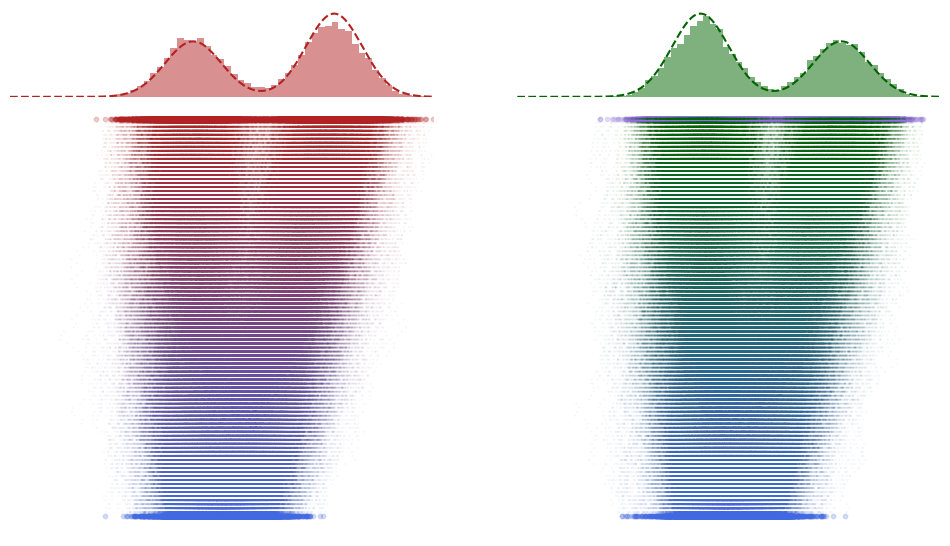

In [16]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 2, height_ratios=[0.2, 1.0, 0.2], hspace=0.01)

ax0 = fig.add_subplot(gs[0, 0])
plt.hist(prior1_trajectory[-1, :, 0], bins=50, density=True, color="firebrick", alpha=0.5)
ax0.plot(x_linspace, p1(x_linspace), label='p1(x)', linestyle="--", color="firebrick")
ax0.set_xlim(x_min, x_max)
ax0.axis("off")

# Add main scatter plot
ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(prior1_trajectory[-1, :, 0], np.ones_like(prior1_trajectory[-1, :, 0]), s=10, alpha=0.2, c="firebrick")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["royalblue", "firebrick"])
ax1.scatter(prior1_trajectory[:, :, 0], np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(prior1_trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(prior1_trajectory[:, :, 0]), cmap=cmap)
ax1.scatter(prior1_trajectory[0, :, 0], np.zeros_like(prior1_trajectory[0, :, 0]), s=10, alpha=0.2, c="royalblue")
ax1.set_xlim(x_min, x_max)
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
plt.hist(prior2_trajectory[-1, :, 0], bins=50, density=True, color="darkgreen", alpha=0.5)
ax2.plot(x_linspace, p2(x_linspace), label='p1(x)', linestyle="--", color="darkgreen")
ax2.set_xlim(x_min, x_max)
ax2.axis("off")

ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(prior2_trajectory[-1, :, 0], np.ones_like(prior2_trajectory[-1, :, 0]), s=10, alpha=0.2, c="mediumpurple")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["royalblue", "darkgreen"])
ax3.scatter(prior2_trajectory[:, :, 0], np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(prior2_trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(prior2_trajectory[:, :, 0]), cmap=cmap)
ax3.scatter(prior2_trajectory[0, :, 0], np.zeros_like(prior2_trajectory[0, :, 0]), s=10, alpha=0.2, c="royalblue")
ax3.set_xlim(x_min, x_max)
ax3.axis("off")

In [54]:
class PosteriorTrainer:
    def __init__(self, reward_fn, dim, prior_model, model, optimizer, batch_size, small_batch_size, num_epochs, buffer_size, device):
        self.reward_fn = reward_fn
        self.dim = dim
        self.prior_model = prior_model
        self.model = model
        self.optimizer = optimizer
        
        self.batch_size = batch_size
        self.small_batch_size = small_batch_size
        self.num_epochs = num_epochs
        
        self.device = device
        
        self.buffer = deque(maxlen=buffer_size)
        
    def train(self):
        self.model.train()
        
        for epoch in range(self.num_epochs):
            # On-policy trajectories
            on_xs, on_ys, on_logpf_posteriors, on_logpf_priors = self.sample_forward(self.batch_size, self.small_batch_size)
            on_xs_unnorm = on_xs * self.data_std + self.data_mean # Unnormalize
            on_rs = self.reward_fn(on_xs_unnorm, on_ys).squeeze()
            
            # Off-policy trajectories
            if len(self.buffer) >= self.batch_size // self.small_batch_size:
                idx = random.sample(range(len(self.buffer)), self.batch_size // self.small_batch_size)
                
                off_xs = torch.stack([self.buffer[i][0] for i in idx]).to(self.device)
                off_ys = torch.stack([self.buffer[i][1] for i in idx]).to(self.device)
                off_rs = torch.stack([self.buffer[i][2] for i in idx]).to(self.device)
                off_logpf_posteriors, off_logpf_priors = self.sample_backward(off_xs, off_ys)
            
                # Combine on-policy and off-policy trajectories
                xs = torch.cat((on_xs, off_xs), dim=0)
                rs = torch.cat((on_rs, off_rs), dim=0)

                logpf_posteriors = torch.cat((on_logpf_posteriors, off_logpf_posteriors), dim=0)
                logpf_priors = torch.cat((on_logpf_priors, off_logpf_priors), dim=0)
            else:
                xs = on_xs
                ys = on_ys
                rs = on_rs
                
                logpf_posteriors = on_logpf_posteriors
                logpf_priors = on_logpf_priors
            
            # Compute RTB-Vargrad loss
            self.optimizer.zero_grad()
            loss = self.compute_loss(logpf_posteriors, logpf_priors, rs)    
            loss.backward() 
            self.optimizer.step()
            
            # Update buffer
            for on_x, on_y, on_r in zip(on_xs, on_ys, on_rs):
                self.buffer.append((on_x.detach(), on_y.detach(), on_r.detach()))
                
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
                
    def compute_loss(self, logpf_posteriors, logpf_priors, rs):
        logrs = torch.log(rs + 1e-20).detach()
        logZs_hat = logpf_priors + logrs - logpf_posteriors
        loss = (logZs_hat - logZs_hat.mean(dim=1, keepdims=True).repeat_interleave(logZs_hat.shape[1], dim=1)).pow(2).mean()
        return loss
    
    def sample_forward(self, batch_size, small_batch_size):
        num_conditions = batch_size // small_batch_size
        
        normal_dist = torch.distributions.Normal(
            torch.zeros(num_conditions, small_batch_size, self.dim).to(self.device),
            torch.ones(num_conditions, small_batch_size, self.dim).to(self.device)
        )
        
        x0 = normal_dist.sample()
        xt = x0.clone()
        y = torch.randint(0, 2, (num_conditions, 1, 1)).to(self.device).repeat_interleave(small_batch_size, dim=1)
        
        logpf_posteriors = normal_dist.log_prob(x0).sum(dim=-1)
        logpf_priors = normal_dist.log_prob(x0).sum(dim=-1)
        for timestep in range(self.model.diffusion_steps):
            t_idx = torch.full((num_conditions, small_batch_size, 1), timestep).to(self.device)
            t = t_idx.float() / self.model.diffusion_steps
            epsilon_pred_reward = self.model.network(torch.cat((xt, t, y), dim=-1))
            epsilon_pred_prior = self.prior_model.network(torch.cat((xt, t, y), dim=-1)).detach()
            epsilon_pred = epsilon_pred_reward + epsilon_pred_prior
            next_xt = self.model.oneover_sqrta[t_idx] * (xt - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred.detach()) + torch.sqrt(self.model.beta_t[t_idx]) * torch.randn_like(xt).to(self.device)   
            
            pf_pi_posterior_dist = torch.distributions.Normal(
                self.model.oneover_sqrta[t_idx] * (xt - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred),
                torch.sqrt(self.model.beta_t[t_idx]) * torch.ones_like(xt).to(self.device)
            )
            
            pf_pi_prior_dist = torch.distributions.Normal(
                self.model.oneover_sqrta[t_idx] * (xt - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred_prior),
                torch.sqrt(self.model.beta_t[t_idx]) * torch.ones_like(xt).to(self.device)
            )
            
            logpf_posteriors += pf_pi_posterior_dist.log_prob(next_xt).sum(dim=-1)
            logpf_priors += pf_pi_prior_dist.log_prob(next_xt).sum(dim=-1)
            
            xt = next_xt
        return xt, y, logpf_posteriors, logpf_priors.detach()
    
    def sample_backward(self, x1, y):
        num_conditions, small_batch_size = x1.shape[0], x1.shape[1]
        
        normal_dist = torch.distributions.Normal(
            torch.zeros(num_conditions, small_batch_size, self.dim).to(self.device),
            torch.ones(num_conditions, small_batch_size, self.dim).to(self.device)
        )
        
        xt = x1.clone()
        
        logpf_posteriors = torch.zeros(num_conditions, small_batch_size).to(self.device)
        logpf_priors = torch.zeros(num_conditions, small_batch_size).to(self.device)
        for timestep in range(self.model.diffusion_steps-1, -1, -1):
            t_idx = torch.full((num_conditions, small_batch_size, 1), timestep).to(self.device)
            t = t_idx.float() / self.model.diffusion_steps
            
            pb_pi_dist = torch.distributions.Normal(
                torch.sqrt(self.model.alpha_t[t_idx]) * xt,
                torch.sqrt(self.model.beta_t[t_idx]) * torch.ones_like(xt).to(self.device)
            )
            
            xt_prev = pb_pi_dist.sample()
            epsilon_pred_reward = self.model.network(torch.cat((xt_prev, t, y), dim=-1))
            epsilon_pred_prior = self.prior_model.network(torch.cat((xt_prev, t, y), dim=-1)).detach()
            epsilon_pred = epsilon_pred_reward + epsilon_pred_prior
            
            pf_pi_posterior_dist = torch.distributions.Normal(
                self.model.oneover_sqrta[t_idx] * (xt_prev - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred),
                torch.sqrt(self.model.beta_t[t_idx]) * torch.ones_like(xt).to(self.device)
            )
            
            pf_pi_prior_dist = torch.distributions.Normal(
                self.model.oneover_sqrta[t_idx] * (xt_prev - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred_prior),
                torch.sqrt(self.model.beta_t[t_idx]) * torch.ones_like(xt).to(self.device)
            )
            
            logpf_posteriors += pf_pi_posterior_dist.log_prob(xt).sum(dim=-1)
            logpf_priors += pf_pi_prior_dist.log_prob(xt).sum(dim=-1)
            
            xt = xt_prev
        logpf_posteriors += normal_dist.log_prob(xt).sum(dim=-1)
        logpf_priors += normal_dist.log_prob(xt).sum(dim=-1)
        return logpf_posteriors, logpf_priors.detach()
    
    def sample(self, sample_size, condition):
        x0 = torch.randn(sample_size, self.dim).to(self.device)
        y = torch.full((sample_size, 1), condition, device=self.device)
        trajectory = []
        xt = x0.clone()
        for timestep in range(self.model.diffusion_steps):
            t_idx = torch.full((sample_size, 1), timestep, device=self.device)
            t = t_idx.float() / self.model.diffusion_steps
            epsilon_pred_reward = self.model.network(torch.cat((xt, t, y), dim=-1))
            epsilon_pred_prior = self.prior_model.network(torch.cat((xt, t, y), dim=-1)).detach()
            epsilon_pred = epsilon_pred_reward + epsilon_pred_prior
            xt = self.model.oneover_sqrta[t_idx] * (xt - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred) + torch.sqrt(self.model.beta_t[t_idx]) * torch.randn_like(xt).to(self.device)   
            trajectory.append((xt * (1 + (self.data_std - 1) * t) + self.data_mean * t).cpu().detach().numpy()) # For smooth visualization
        trajectory = np.stack(trajectory, axis=0)
        return trajectory

In [55]:
buffer_size = 5000
small_batch_size = 64
posterior_num_epochs = 1000

In [56]:
posterior_network = MLP(input_dim=dim + 2, hidden_dim=hidden_dim, output_dim=dim).to(device)
posterior_model = DiffusionModel(posterior_network, diffusion_steps).to(device)
posterior_model.load_state_dict(prior_model.state_dict())
posterior_optimizer = optim.Adam(posterior_model.parameters(), lr=learning_rate)    
posterior_trainer = PosteriorTrainer(r, dim, prior_model, posterior_model, posterior_optimizer, batch_size, small_batch_size, posterior_num_epochs, buffer_size, device)

posterior_trainer.data_mean = dataset.data_mean.to(device)
posterior_trainer.data_std = dataset.data_std.to(device)
posterior_trainer.train()

Epoch 0, Loss: 1.8087
Epoch 50, Loss: 0.8094
Epoch 100, Loss: 0.4687
Epoch 150, Loss: 0.3345
Epoch 200, Loss: 0.3028
Epoch 250, Loss: 0.2767
Epoch 300, Loss: 0.2549
Epoch 350, Loss: 0.2456
Epoch 400, Loss: 0.2630
Epoch 450, Loss: 0.2534
Epoch 500, Loss: 0.2685
Epoch 550, Loss: 0.2972
Epoch 600, Loss: 0.2322
Epoch 650, Loss: 0.2832
Epoch 700, Loss: 0.2824
Epoch 750, Loss: 0.2333
Epoch 800, Loss: 0.2626
Epoch 850, Loss: 0.2369
Epoch 900, Loss: 0.2534
Epoch 950, Loss: 0.2599


In [57]:
posterior1_trajectory = posterior_trainer.sample(num_samples // 2, 0)
posterior2_trajectory = posterior_trainer.sample(num_samples // 2, 1)

(-7.5, 7.5, -0.05, 1.05)

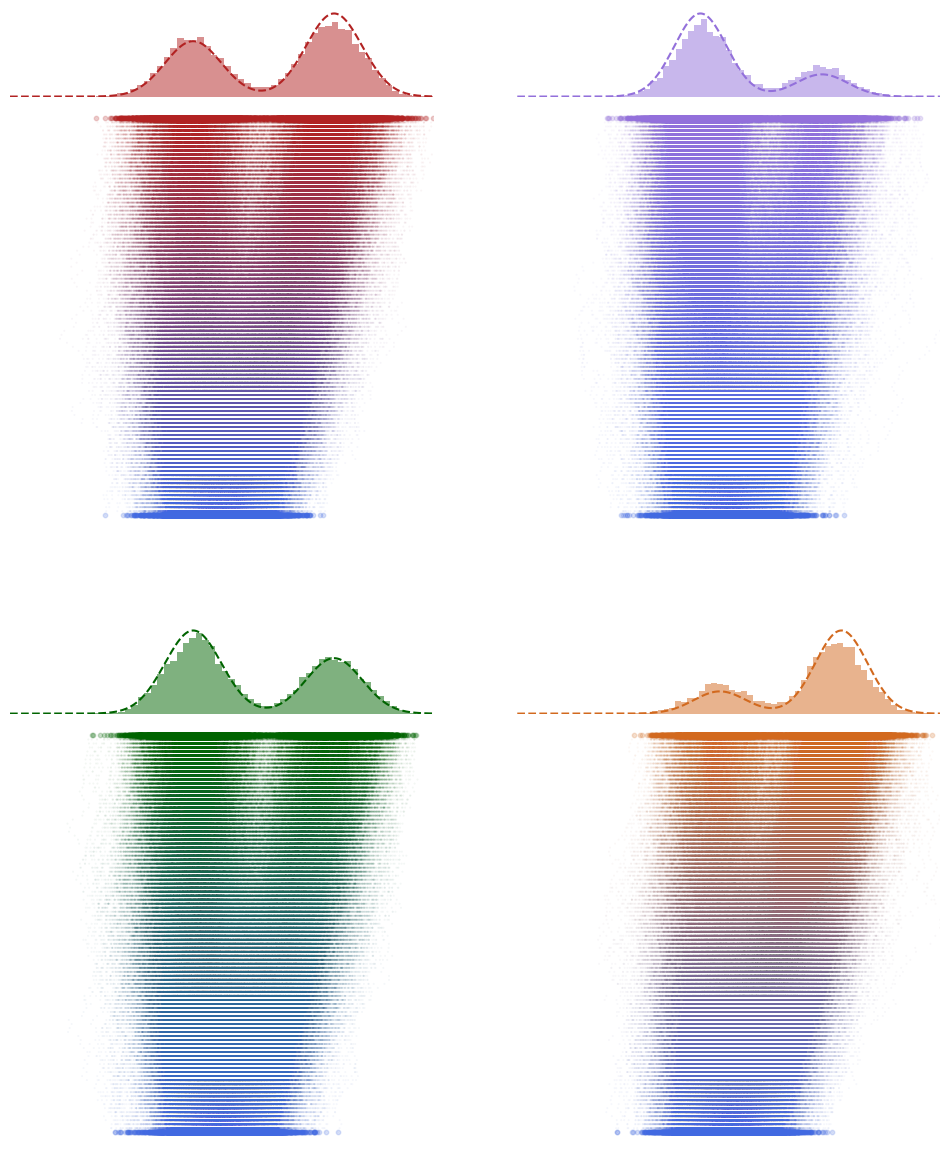

In [61]:
fig = plt.figure(figsize=(12, 16))
gs = fig.add_gridspec(6, 2, height_ratios=[0.2, 1.0, 0.2, 0.2, 1.0, 0.2], hspace=0.01)

ax0 = fig.add_subplot(gs[0, 0])
plt.hist(prior1_trajectory[-1, :, 0], bins=50, density=True, color="firebrick", alpha=0.5)
ax0.plot(x_linspace, p1(x_linspace), label='p1(x)', linestyle="--", color="firebrick")
ax0.set_xlim(x_min, x_max)
ax0.axis("off")

ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(prior1_trajectory[-1, :, 0], np.ones_like(prior1_trajectory[-1, :, 0]), s=10, alpha=0.2, c="firebrick")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["royalblue", "firebrick"])
ax1.scatter(prior1_trajectory[:, :, 0], np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(prior1_trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(prior1_trajectory[:, :, 0]), cmap=cmap)
ax1.scatter(prior1_trajectory[0, :, 0], np.zeros_like(prior1_trajectory[0, :, 0]), s=10, alpha=0.2, c="royalblue")
ax1.set_xlim(x_min, x_max)
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
plt.hist(posterior1_trajectory[-1, :, 0], bins=50, density=True, color="mediumpurple", alpha=0.5)
ax2.plot(x_linspace, pr1(x_linspace), label='p(x) $\propto$ p1(x) r1(x)', linestyle="--", color="mediumpurple")
ax2.set_xlim(x_min, x_max)
ax2.axis("off")

ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(posterior1_trajectory[-1, :, 0], np.ones_like(posterior1_trajectory[-1, :, 0]), s=10, alpha=0.2, c="mediumpurple")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["royalblue", "mediumpurple"])
ax3.scatter(posterior1_trajectory[:, :, 0], np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(posterior1_trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(posterior1_trajectory[:, :, 0]), cmap=cmap)
ax3.scatter(posterior1_trajectory[0, :, 0], np.zeros_like(posterior1_trajectory[0, :, 0]), s=10, alpha=0.2, c="royalblue")
ax3.set_xlim(x_min, x_max)
ax3.axis("off")

ax4 = fig.add_subplot(gs[3, 0])
plt.hist(prior2_trajectory[-1, :, 0], bins=50, density=True, color="darkgreen", alpha=0.5)
ax4.plot(x_linspace, p2(x_linspace), label='p2(x)', linestyle="--", color="darkgreen")
ax4.set_xlim(x_min, x_max)
ax4.axis("off")

ax5 = fig.add_subplot(gs[4, 0])
ax5.scatter(prior2_trajectory[-1, :, 0], np.ones_like(prior2_trajectory[-1, :, 0]), s=10, alpha=0.2, c="darkgreen")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["royalblue", "darkgreen"])
ax5.scatter(prior2_trajectory[:, :, 0], np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(prior2_trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(prior2_trajectory[:, :, 0]), cmap=cmap)
ax5.scatter(prior2_trajectory[0, :, 0], np.zeros_like(prior2_trajectory[0, :, 0]), s=10, alpha=0.2, c="royalblue")
ax5.set_xlim(x_min, x_max)
ax5.axis("off")

ax6 = fig.add_subplot(gs[3, 1])
plt.hist(posterior2_trajectory[-1, :, 0], bins=50, density=True, color="chocolate", alpha=0.5)
ax6.plot(x_linspace, pr2(x_linspace), label='p(x) $\propto$ p2(x) r2(x)', linestyle="--", color="chocolate")
ax6.set_xlim(x_min, x_max)
ax6.axis("off")

ax7 = fig.add_subplot(gs[4, 1])
ax7.scatter(posterior2_trajectory[-1, :, 0], np.ones_like(posterior2_trajectory[-1, :, 0]), s=10, alpha=0.2, c="chocolate")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["royalblue", "chocolate"])
ax7.scatter(posterior2_trajectory[:, :, 0], np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(posterior2_trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(posterior2_trajectory[:, :, 0]), cmap=cmap)
ax7.scatter(posterior2_trajectory[0, :, 0], np.zeros_like(posterior2_trajectory[0, :, 0]), s=10, alpha=0.2, c="royalblue")
ax7.set_xlim(x_min, x_max)
ax7.axis("off")